In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

import seaborn as sns

import matplotlib as mpl
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

from matplotlib.ticker import MultipleLocator
plt.rcParams['axes.linewidth'] = 2.0

## Funções auxiliares

In [2]:
def mount_cv_df(results):
    df = pd.concat([
        pd.DataFrame(results["params"]),
        pd.DataFrame(results["mean_test_score"]),
        pd.DataFrame(results["std_test_score"])
    ], axis=1)
    
    df.columns = ["C", "degree", "kernel", "acc", "std"]
    df.loc[df.kernel=="linear", "degree"] = pd.NA
    return df.drop_duplicates().sort_values(by=["C", "degree", "kernel"])

In [3]:
def mount_classification_report(preds):
    y_test = preds.y_test.values
    y_pred = preds.y_pred.values
    return classification_report(y_test, y_pred), accuracy_score(y_test, y_pred)

In [4]:
def clear_error(s):
    s = s.replace(r"train:", "").strip()
    s = s.replace(r"valid:", "").strip()
    s = s.replace(r"grad_norm:", "").strip()
    s = s.replace(r"cross_entropy:", "").strip()
    return s

In [5]:
def make_loss_plot(df_loss, path, model):
    fig, ax = plt.subplots(dpi=300)
    df_loss[["train_loss", "val_loss"]].rename(columns={"train_loss": "Loss Treino", "val_loss": "Loss Validação"}).plot(ax=ax, color=['red', 'blue'])
    ax.legend()
    plt.title(f"{model}: evolução da perda ao longo das\n épocas")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.savefig(path)

---

## SVM

In [6]:
hog_preds = pd.read_csv("../execucao/HOG-preds.csv")
lbp_preds = pd.read_csv("../execucao/LBP-preds.csv")

with open("../execucao/HOG-results.pkl", "rb") as f:
    svm_hog_results = pickle.load(f)

with open("../execucao/LBP-results.pkl", "rb") as f:
    svm_lbp_results = pickle.load(f)

In [7]:
print((
    mount_cv_df(svm_lbp_results)
    .to_latex(index=False)
))

\begin{tabular}{rrlrr}
\toprule
   C &  degree & kernel &      acc &      std \\
\midrule
  10 &     2.0 &   poly & 0.606711 & 0.012448 \\
  10 &     3.0 &   poly & 0.539150 & 0.027399 \\
  10 &     NaN & linear & 0.522595 & 0.011372 \\
 100 &     2.0 &   poly & 0.602237 & 0.008653 \\
 100 &     3.0 &   poly & 0.538702 & 0.026749 \\
 100 &     NaN & linear & 0.522595 & 0.011372 \\
1000 &     2.0 &   poly & 0.604027 & 0.011838 \\
1000 &     3.0 &   poly & 0.537360 & 0.028907 \\
1000 &     NaN & linear & 0.520805 & 0.012286 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_14612/982174666.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  mount_cv_df(svm_lbp_results)


In [8]:
svm_hog_report, svm_hog_acc = mount_classification_report(hog_preds)

In [9]:
svm_lbp_report, svm_lbp_acc = mount_classification_report(lbp_preds)

---

## MLP

In [10]:
hog_preds = pd.read_csv("../resultados/MLP/HOG/compare_y.csv")
lbp_preds = pd.read_csv("../resultados/MLP/LBP/compare_y.csv")

hog_preds.columns = ["y_test", "y_pred"]
lbp_preds.columns = ["y_test", "y_pred"]

In [11]:
mlp_hog_report, mlp_hog_acc = mount_classification_report(hog_preds)
mlp_lbp_report, mlp_lbp_acc = mount_classification_report(lbp_preds)

/home/itsmeale/code/SIN5016/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/itsmeale/code/SIN5016/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/itsmeale/code/SIN5016/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [12]:
train_loss_c = "train_loss"
val_loss_c = "val_loss"

In [13]:
error_hog_mlp = pd.read_csv("../resultados/MLP/HOG/error.txt", header=None)
error_hog_mlp.columns = ["epoch", train_loss_c, val_loss_c]
error_lbp_mlp = pd.read_csv("../resultados/MLP/LBP/error.txt", header=None)
error_lbp_mlp.columns = ["epoch", train_loss_c, val_loss_c]

In [14]:
error_hog_mlp[train_loss_c] = error_hog_mlp[train_loss_c].apply(clear_error).astype(np.float64)
error_hog_mlp[val_loss_c] = error_hog_mlp[val_loss_c].apply(clear_error).astype(np.float64)
error_lbp_mlp[train_loss_c] = error_lbp_mlp[train_loss_c].apply(clear_error).astype(np.float64)
error_lbp_mlp[val_loss_c] = error_lbp_mlp[val_loss_c].apply(clear_error).astype(np.float64)

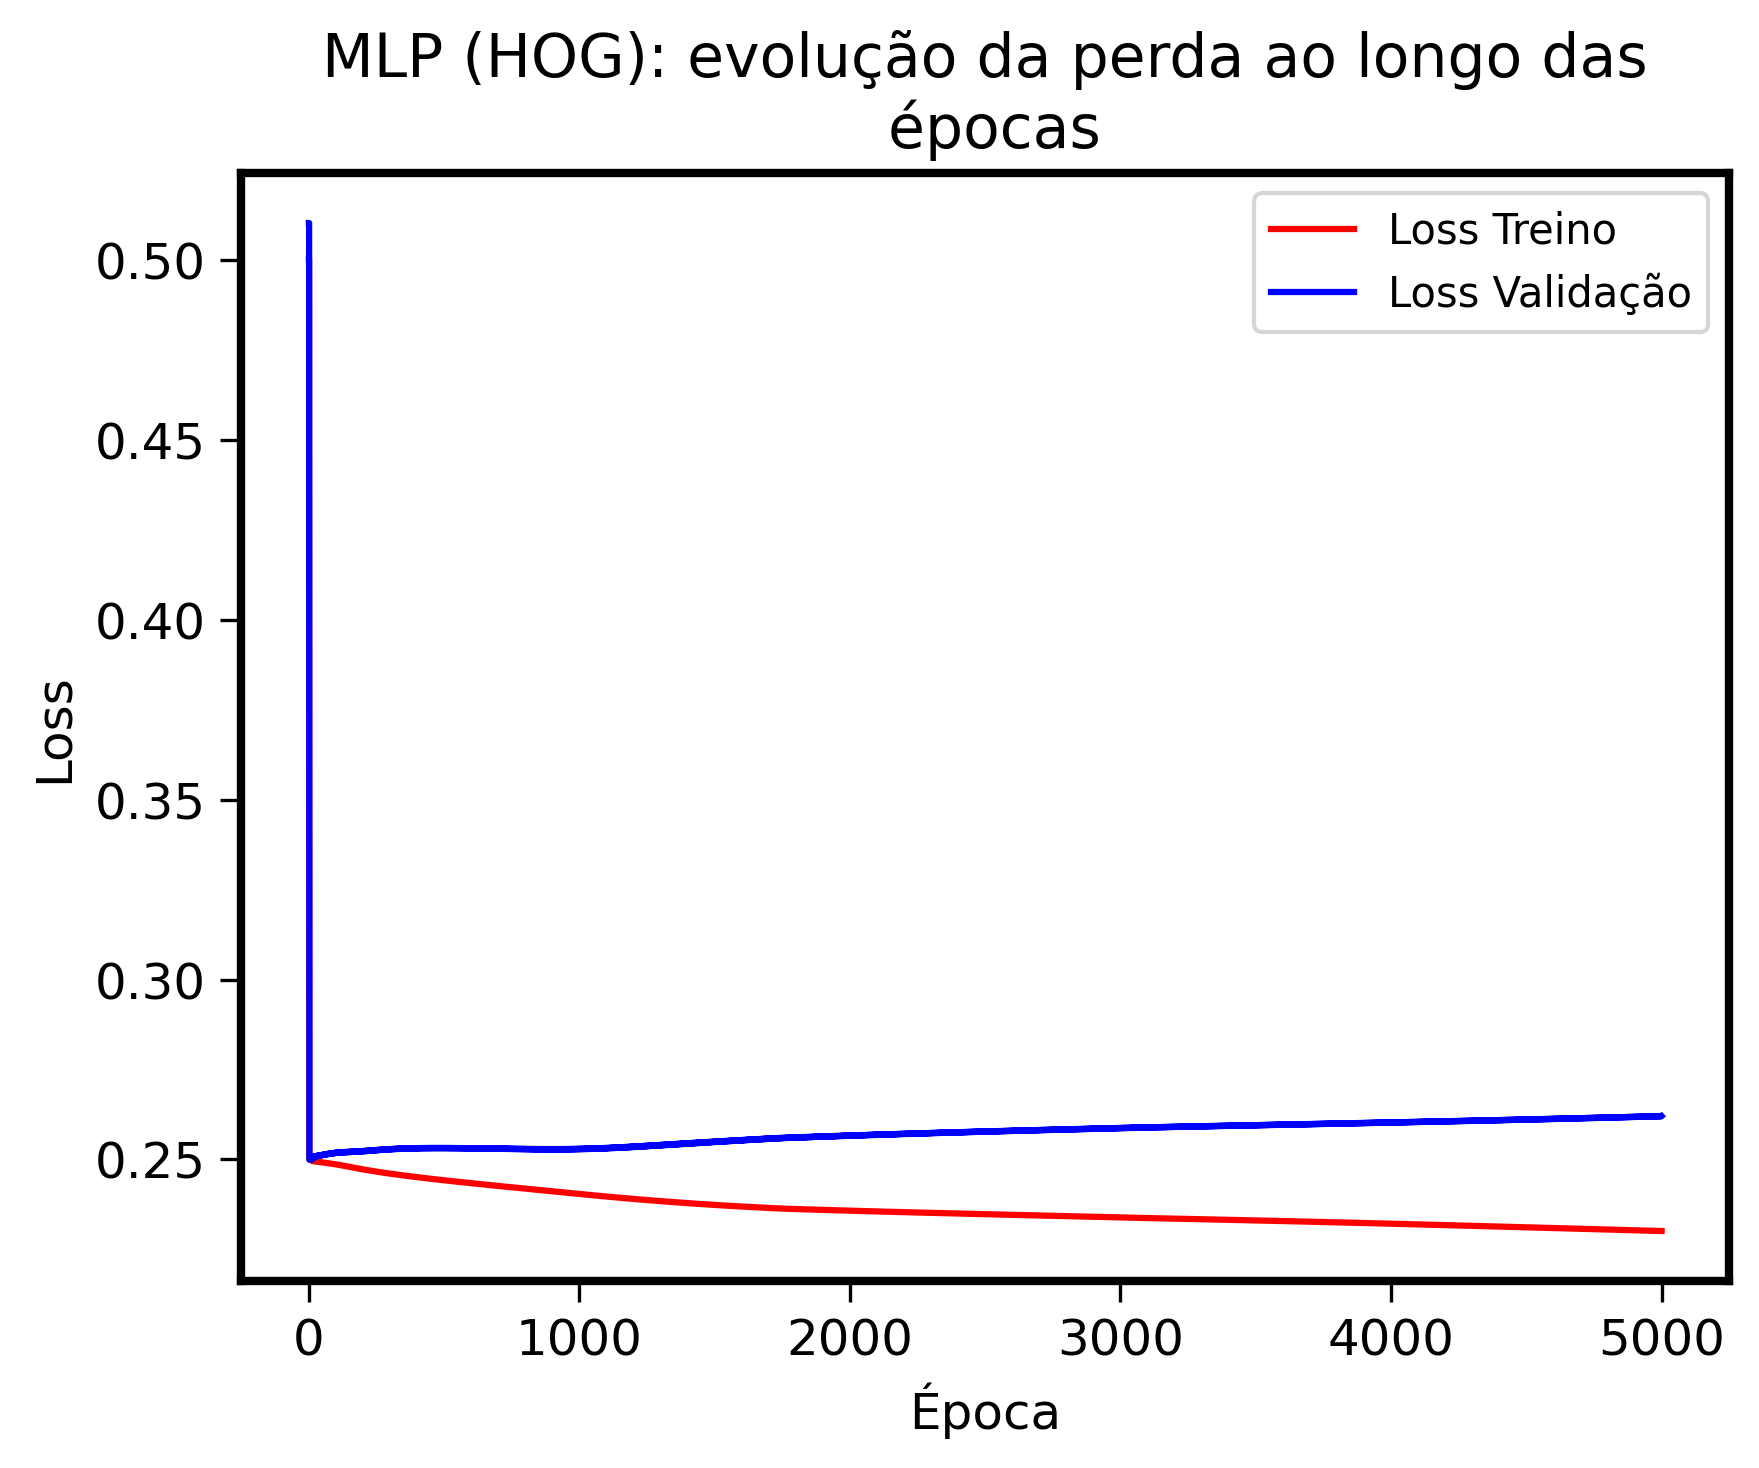

In [15]:
make_loss_plot(error_hog_mlp, "../viz/mlp_hog_loss.pdf", "MLP (HOG)")

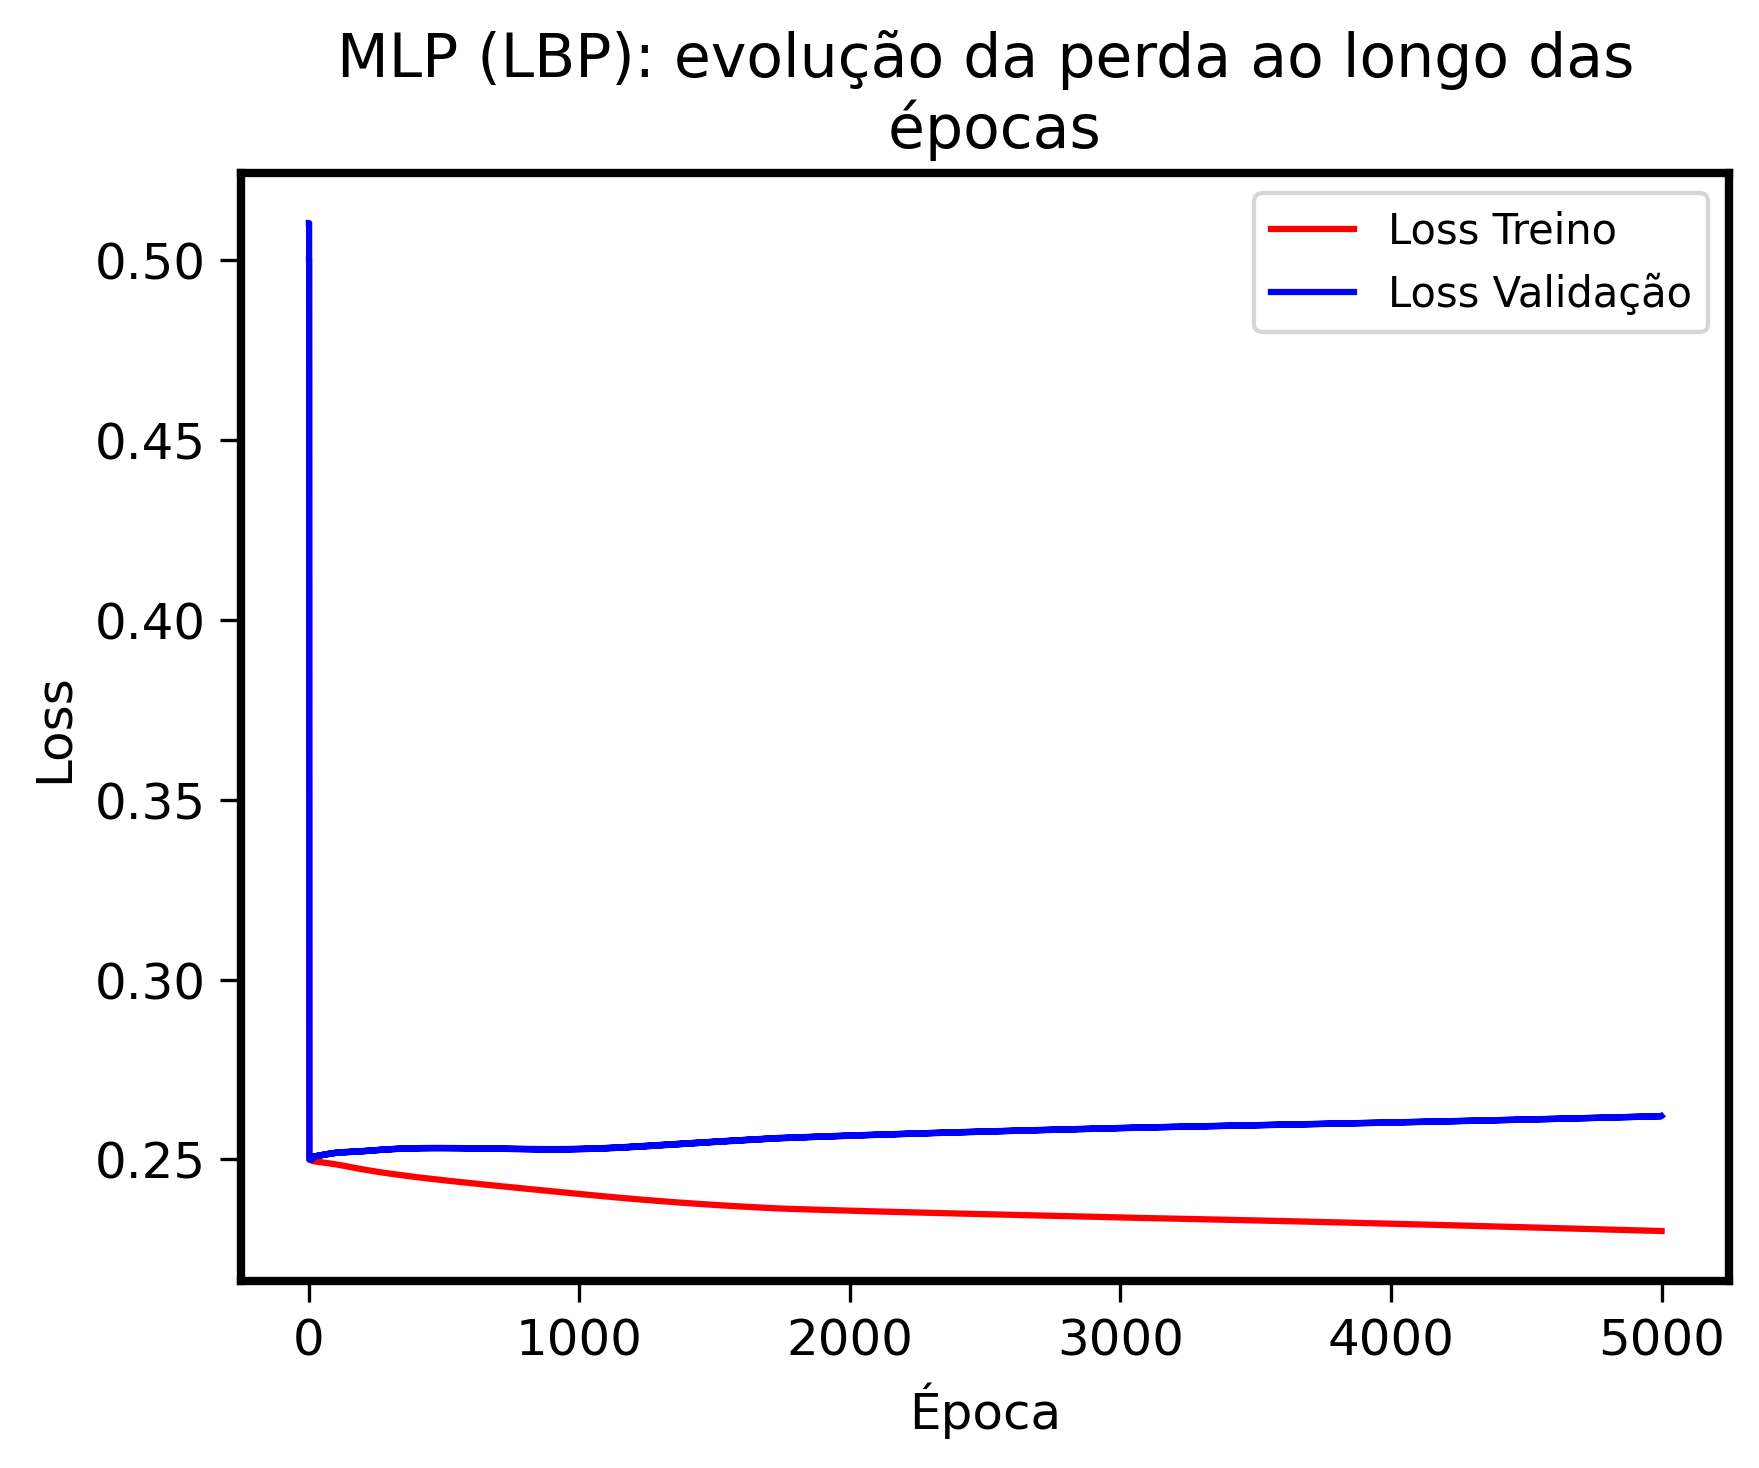

In [16]:
make_loss_plot(error_hog_mlp, "../viz/mlp_lbp_loss.pdf", "MLP (LBP)")

---

## Regressão Logística

In [17]:
hog_preds = pd.read_csv("../resultados/RegLog/HOG/compare_y.csv")
lbp_preds = pd.read_csv("../resultados/RegLog/LBP/compare_y.csv")

hog_preds.columns = ["y_test", "y_pred"]
lbp_preds.columns = ["y_test", "y_pred"]

In [18]:
reglog_hog_report, reglog_hog_acc = mount_classification_report(hog_preds)
reglog_lbp_report, reglog_lbp_acc = mount_classification_report(lbp_preds)

In [19]:
train_loss_c = "grad_norm"
val_loss_c = "cross_entropy"

In [20]:
error_hog_reglog = pd.read_csv("../resultados/RegLog/HOG/error.txt", header=None)
error_hog_reglog.columns = ["epoch", train_loss_c, val_loss_c]
error_lbp_reglog = pd.read_csv("../resultados/RegLog/LBP/error.txt", header=None)
error_lbp_reglog.columns = ["epoch", train_loss_c, val_loss_c]

In [21]:
error_hog_reglog[train_loss_c] = error_hog_reglog[train_loss_c].apply(clear_error).astype(np.float64)
error_hog_reglog[val_loss_c] = error_hog_reglog[val_loss_c].apply(clear_error).astype(np.float64)
error_lbp_reglog[train_loss_c] = error_lbp_reglog[train_loss_c].apply(clear_error).astype(np.float64)
error_lbp_reglog[val_loss_c] = error_lbp_reglog[val_loss_c].apply(clear_error).astype(np.float64)

In [22]:
error_hog_reglog

,epoch,grad_norm,cross_entropy
0,it: 0,14840.766019,3.901481
1,it: 1,2145.788826,0.727827
2,it: 2,581.811462,0.716872
3,it: 3,500.514269,0.715711
4,it: 4,429.037614,0.714671
...,...,...,...
9996,it: 9996,0.089290,0.678864
9997,it: 9997,0.182205,0.678864
9998,it: 9998,0.080520,0.678864
9999,it: 9999,0.400185,0.678864


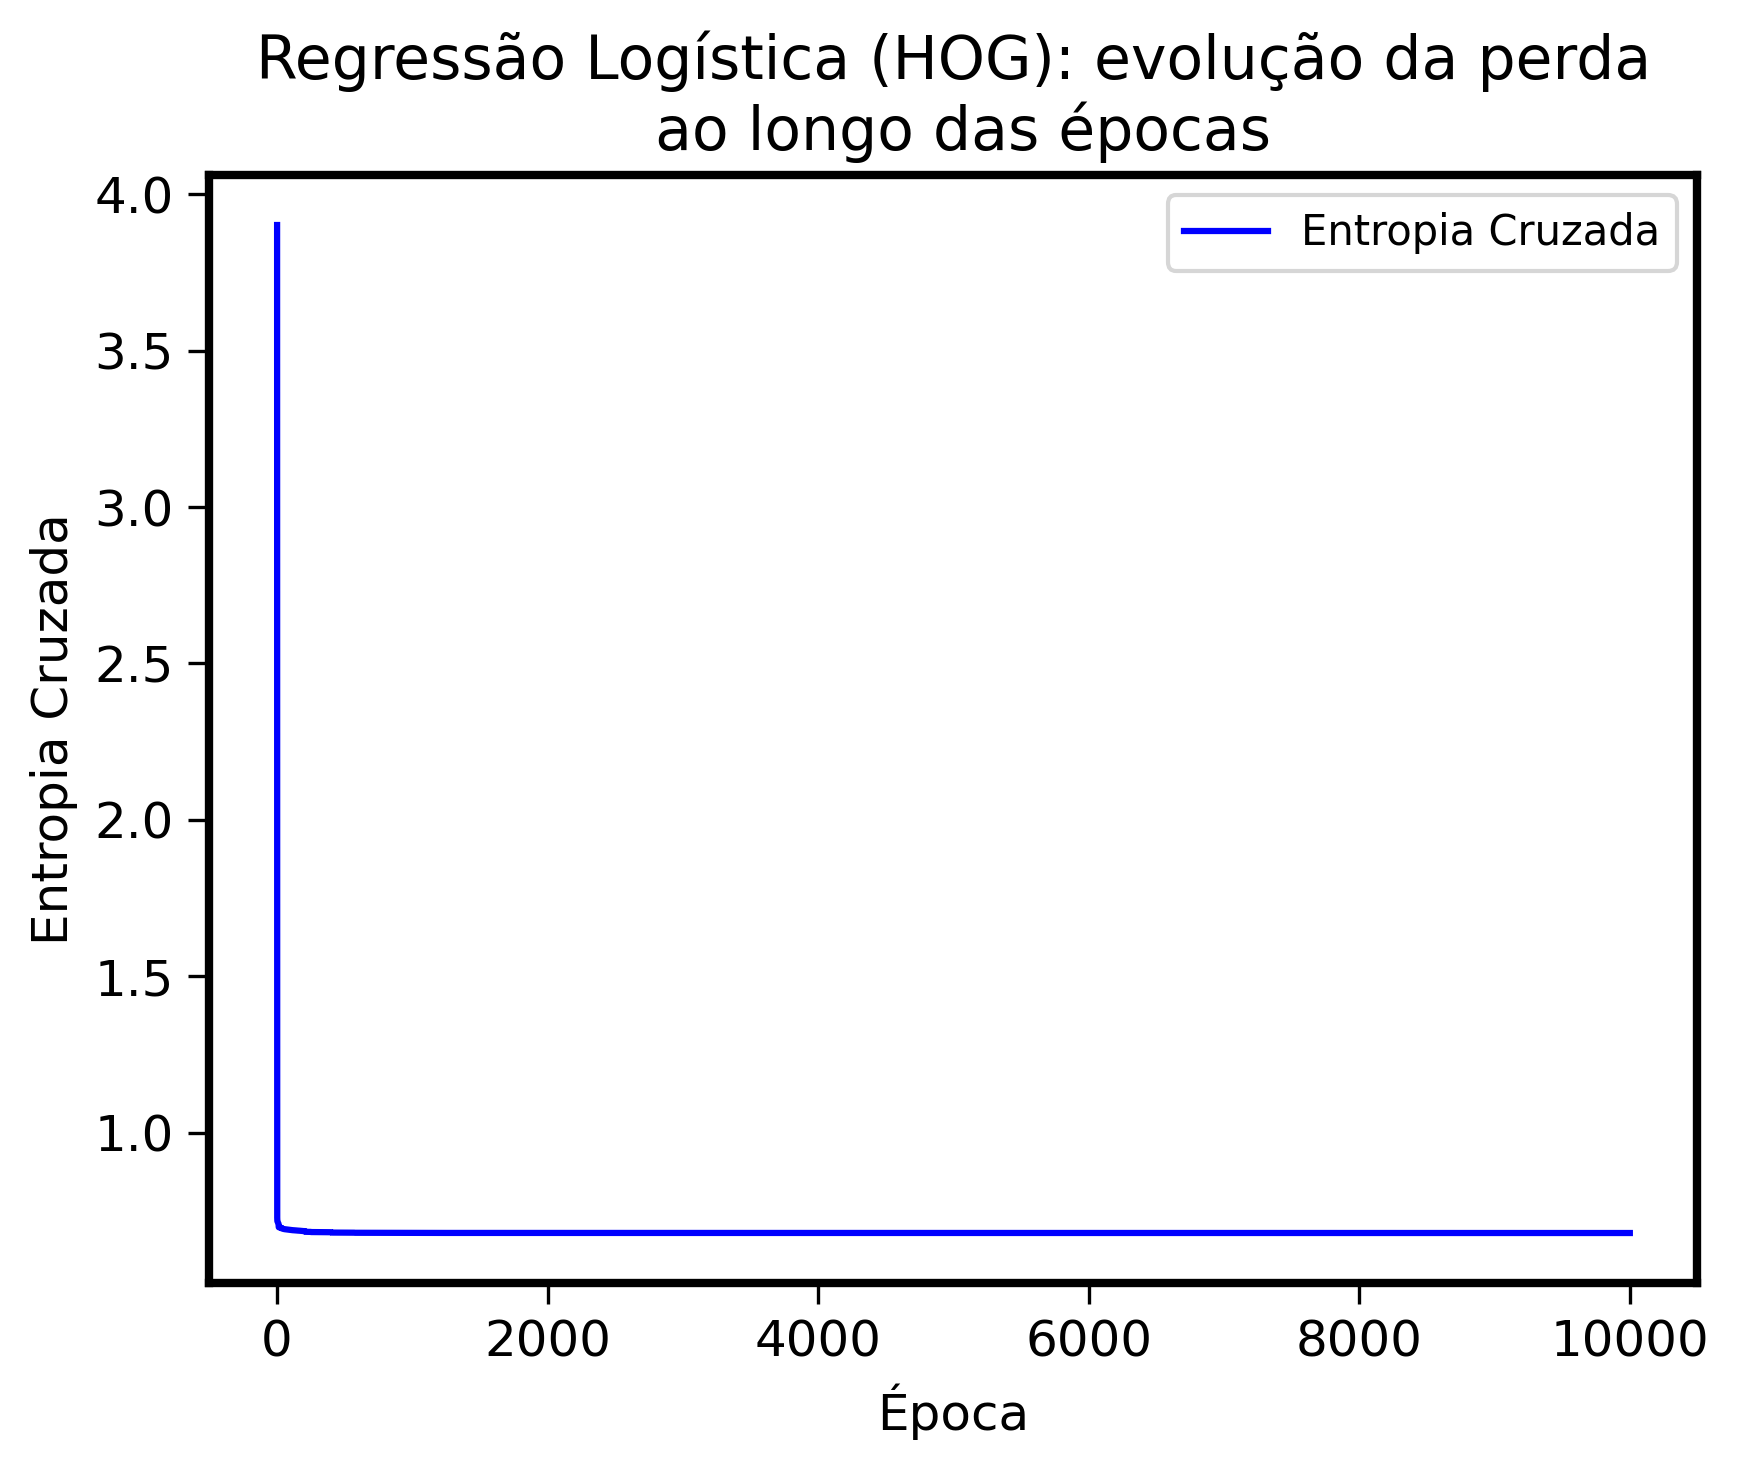

In [23]:
fig, ax = plt.subplots(dpi=300)

error_hog_reglog[["cross_entropy"]].rename(columns={"cross_entropy": "Entropia Cruzada"}).plot(ax=ax, color=['blue'])
ax.legend()
plt.title("Regressão Logística (HOG): evolução da perda\n ao longo das épocas")
plt.xlabel("Época")
plt.ylabel("Entropia Cruzada")

plt.savefig("../viz/loss_reglog_hog.pdf")

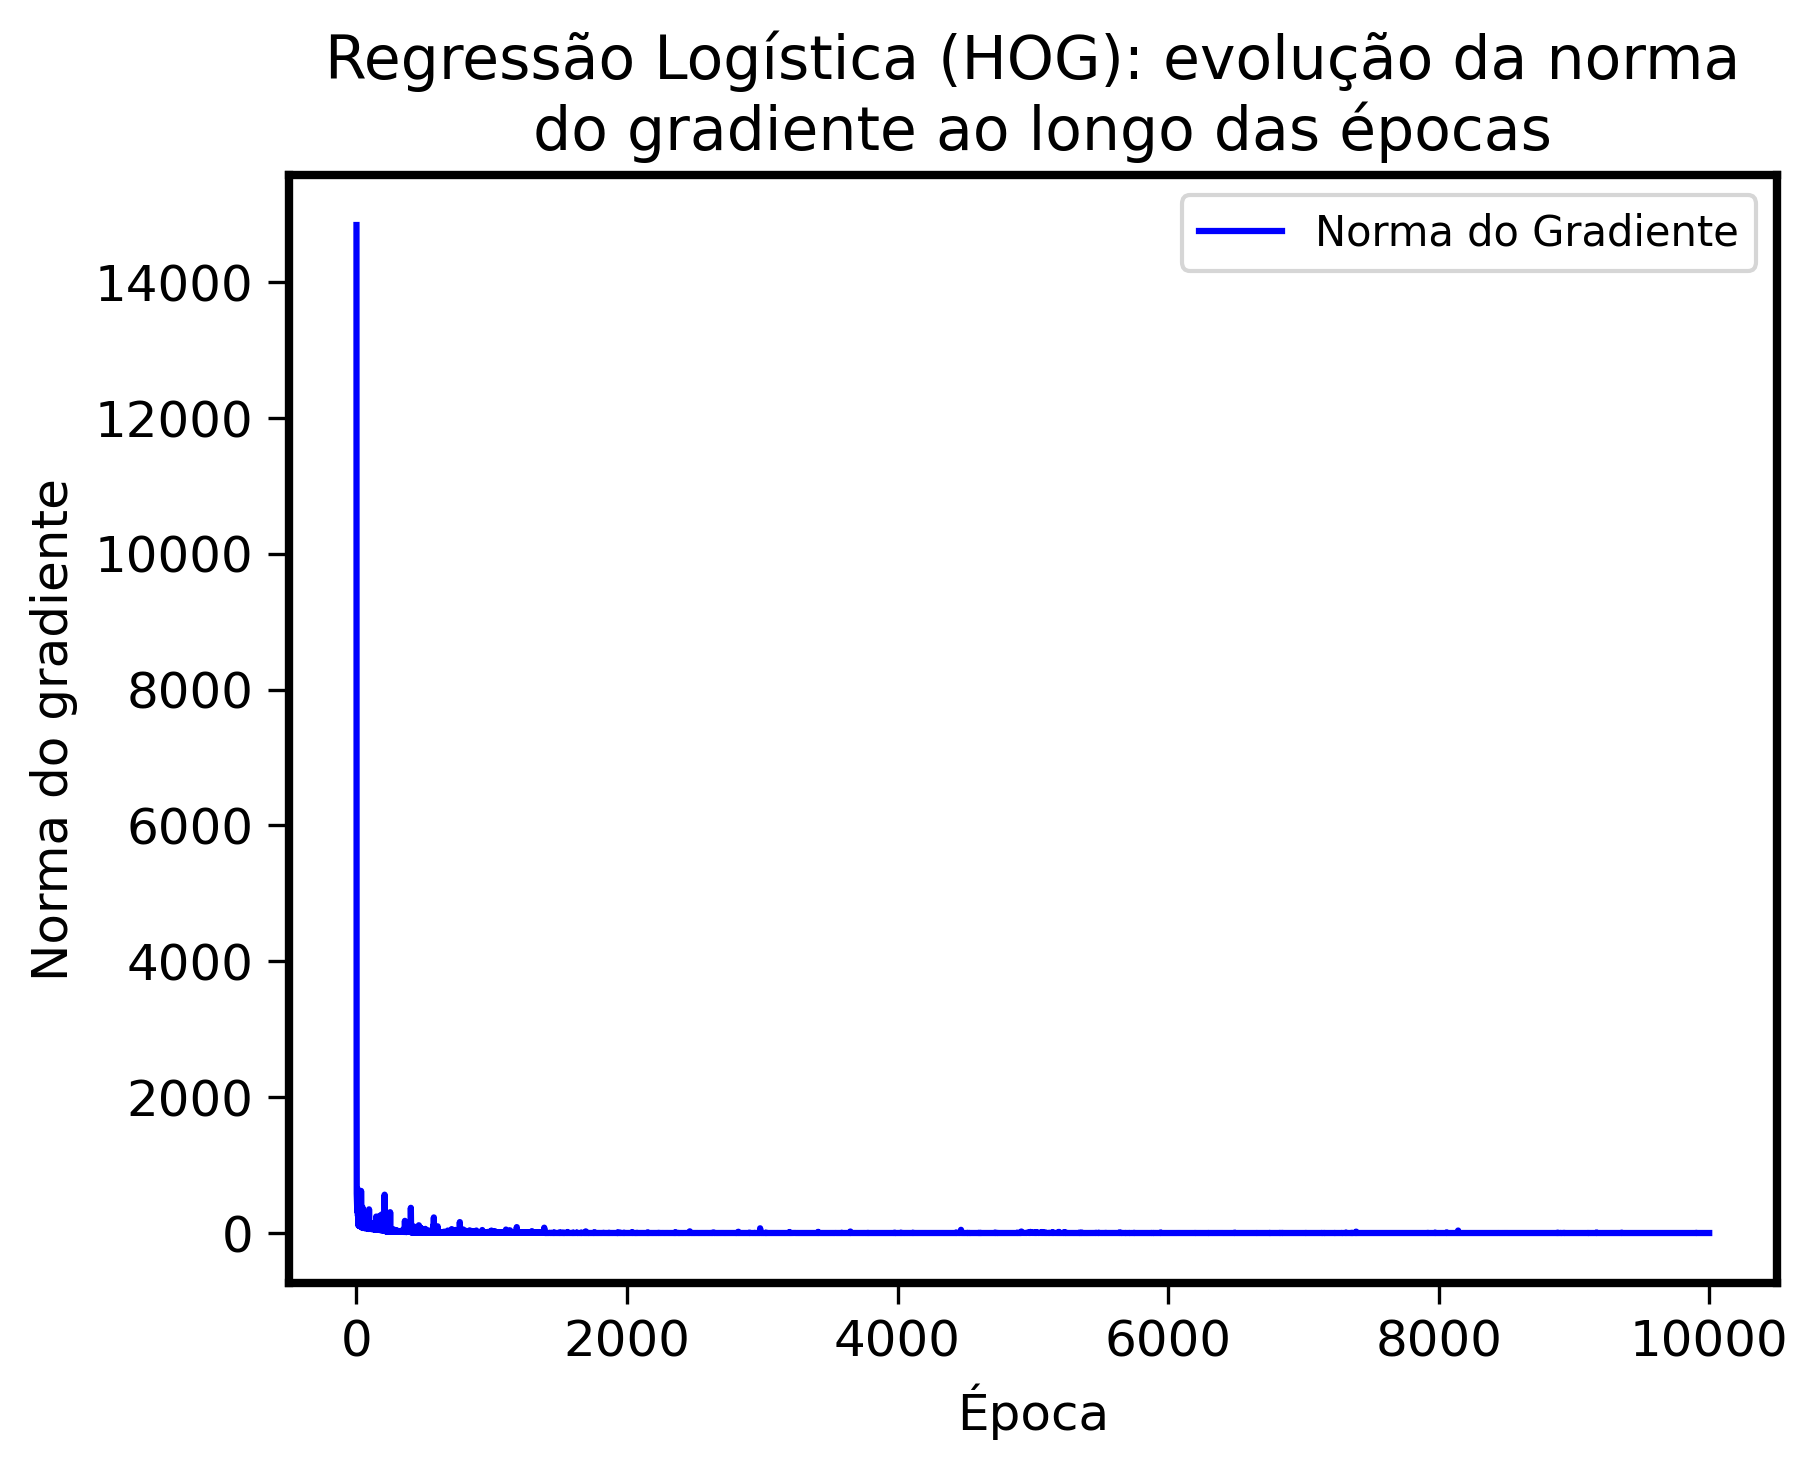

In [24]:
fig, ax = plt.subplots(dpi=300)

error_hog_reglog[["grad_norm"]].rename(columns={"grad_norm": "Norma do Gradiente"}).plot(ax=ax, color=['blue'])
ax.legend()
plt.title("Regressão Logística (HOG): evolução da norma\n do gradiente ao longo das épocas")
plt.xlabel("Época")
plt.ylabel("Norma do gradiente")

plt.savefig("../viz/grad_norm_reglog_hog.pdf")

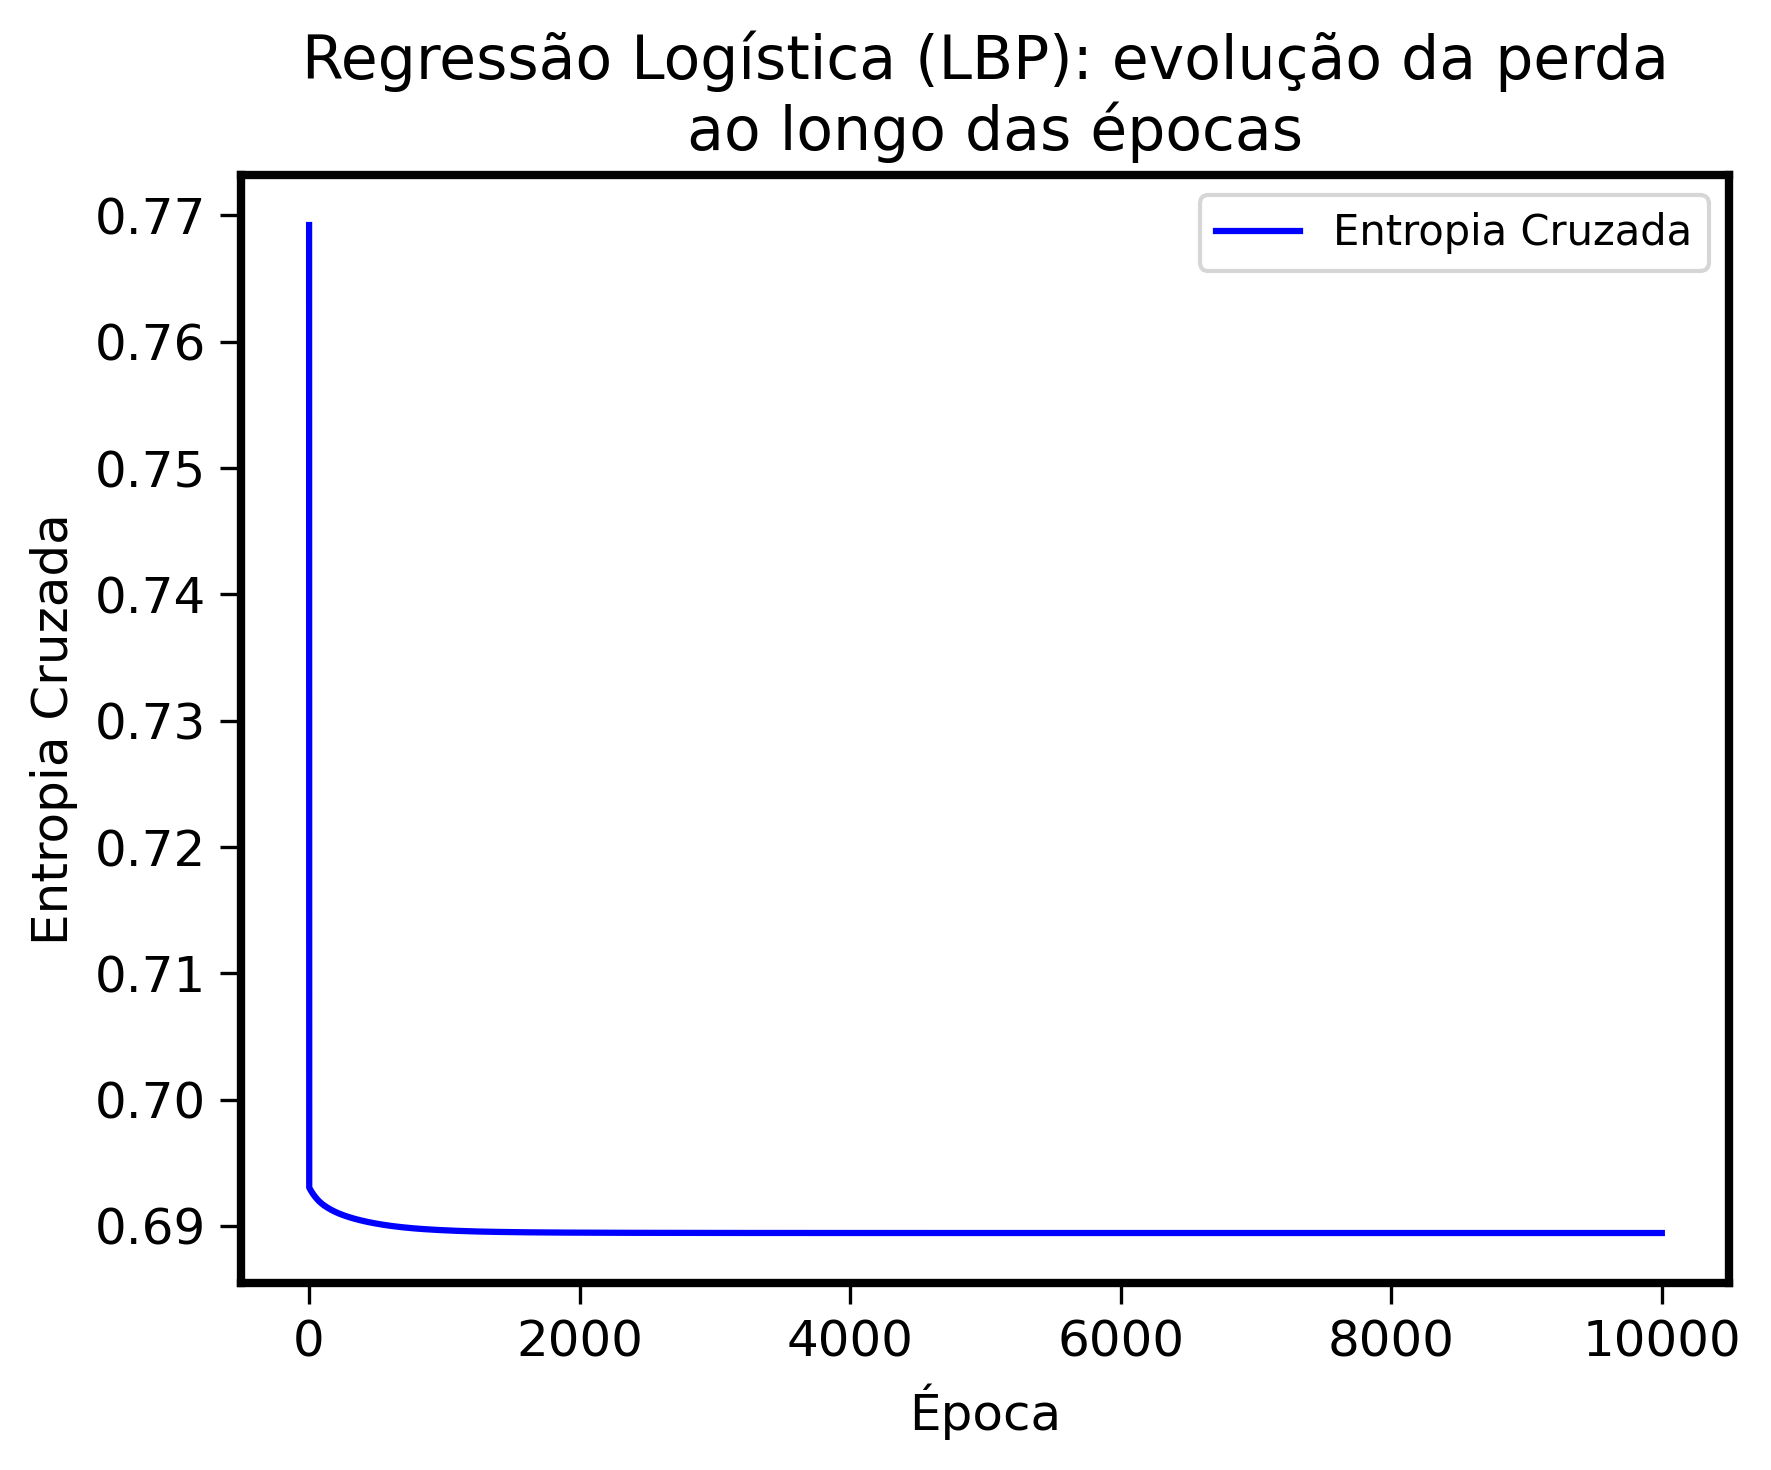

In [25]:
fig, ax = plt.subplots(dpi=300)

error_lbp_reglog[["cross_entropy"]].rename(columns={"cross_entropy": "Entropia Cruzada"}).plot(ax=ax, color=['blue'])
ax.legend()
plt.title("Regressão Logística (LBP): evolução da perda\n ao longo das épocas")
plt.xlabel("Época")
plt.ylabel("Entropia Cruzada")

plt.savefig("../viz/loss_reglog_lbp.pdf")

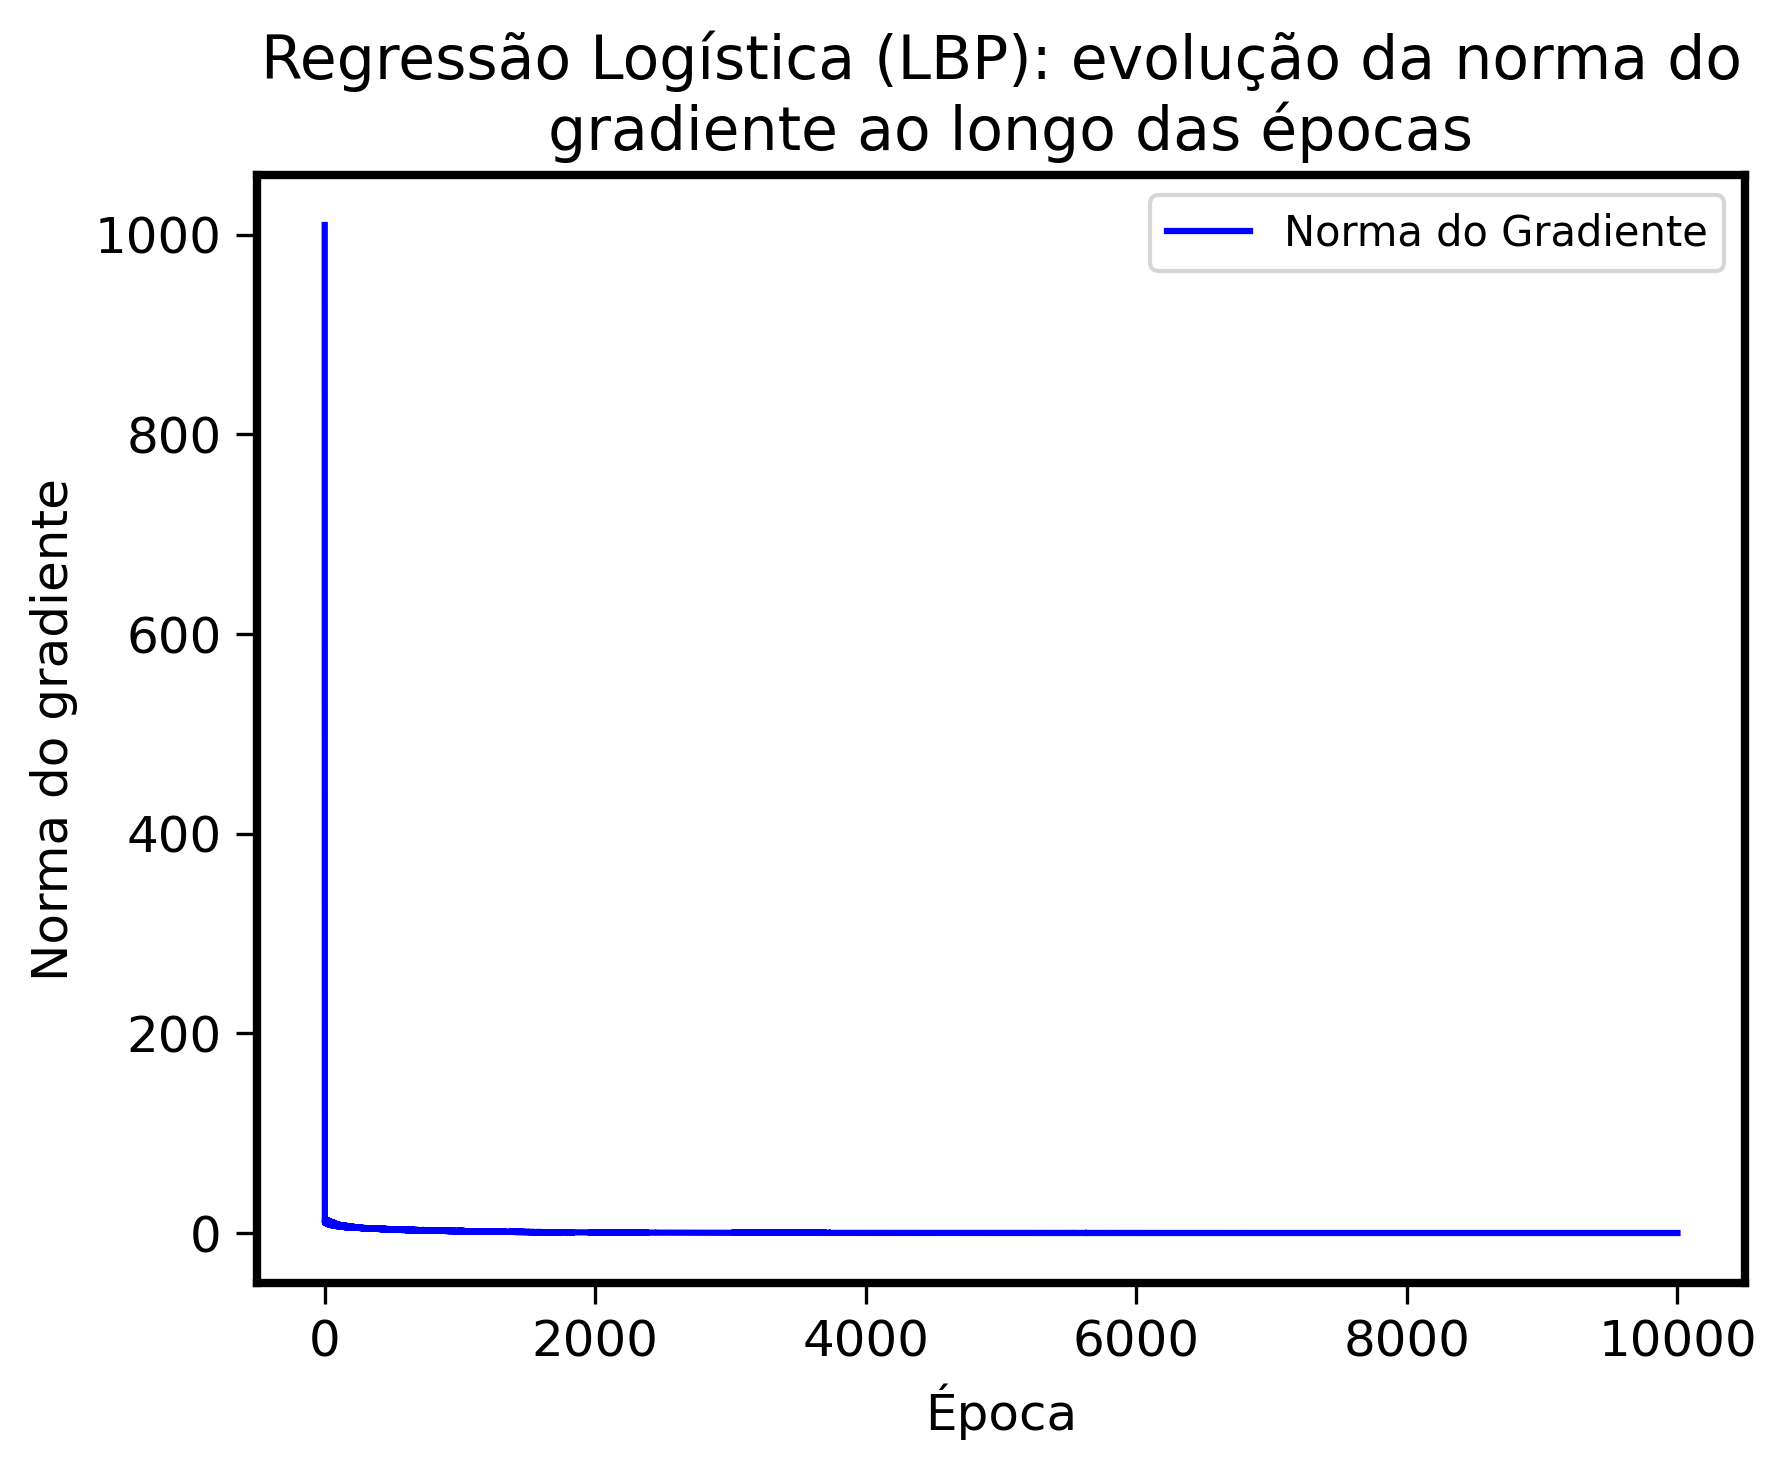

In [26]:
fig, ax = plt.subplots(dpi=300)

error_lbp_reglog[["grad_norm"]].rename(columns={"grad_norm": "Norma do Gradiente"}).plot(ax=ax, color=['blue'])
ax.legend()
plt.title("Regressão Logística (LBP): evolução da norma do\n gradiente ao longo das épocas")
plt.xlabel("Época")
plt.ylabel("Norma do gradiente")

plt.savefig("../viz/grad_norm_reglog_lbp.pdf")

---
## ConvNet

In [27]:
cnet_preds = pd.read_csv("../execucao/convnet_test_preds.csv")
cnet_preds.columns = ["y_test", "y_pred"]

In [28]:
cnet_report, cnet_acc = mount_classification_report(cnet_preds)

In [29]:
cnet_acc

0.6489583333333333

In [30]:
df_loss = pd.read_csv("../execucao/convnet_loss.csv")

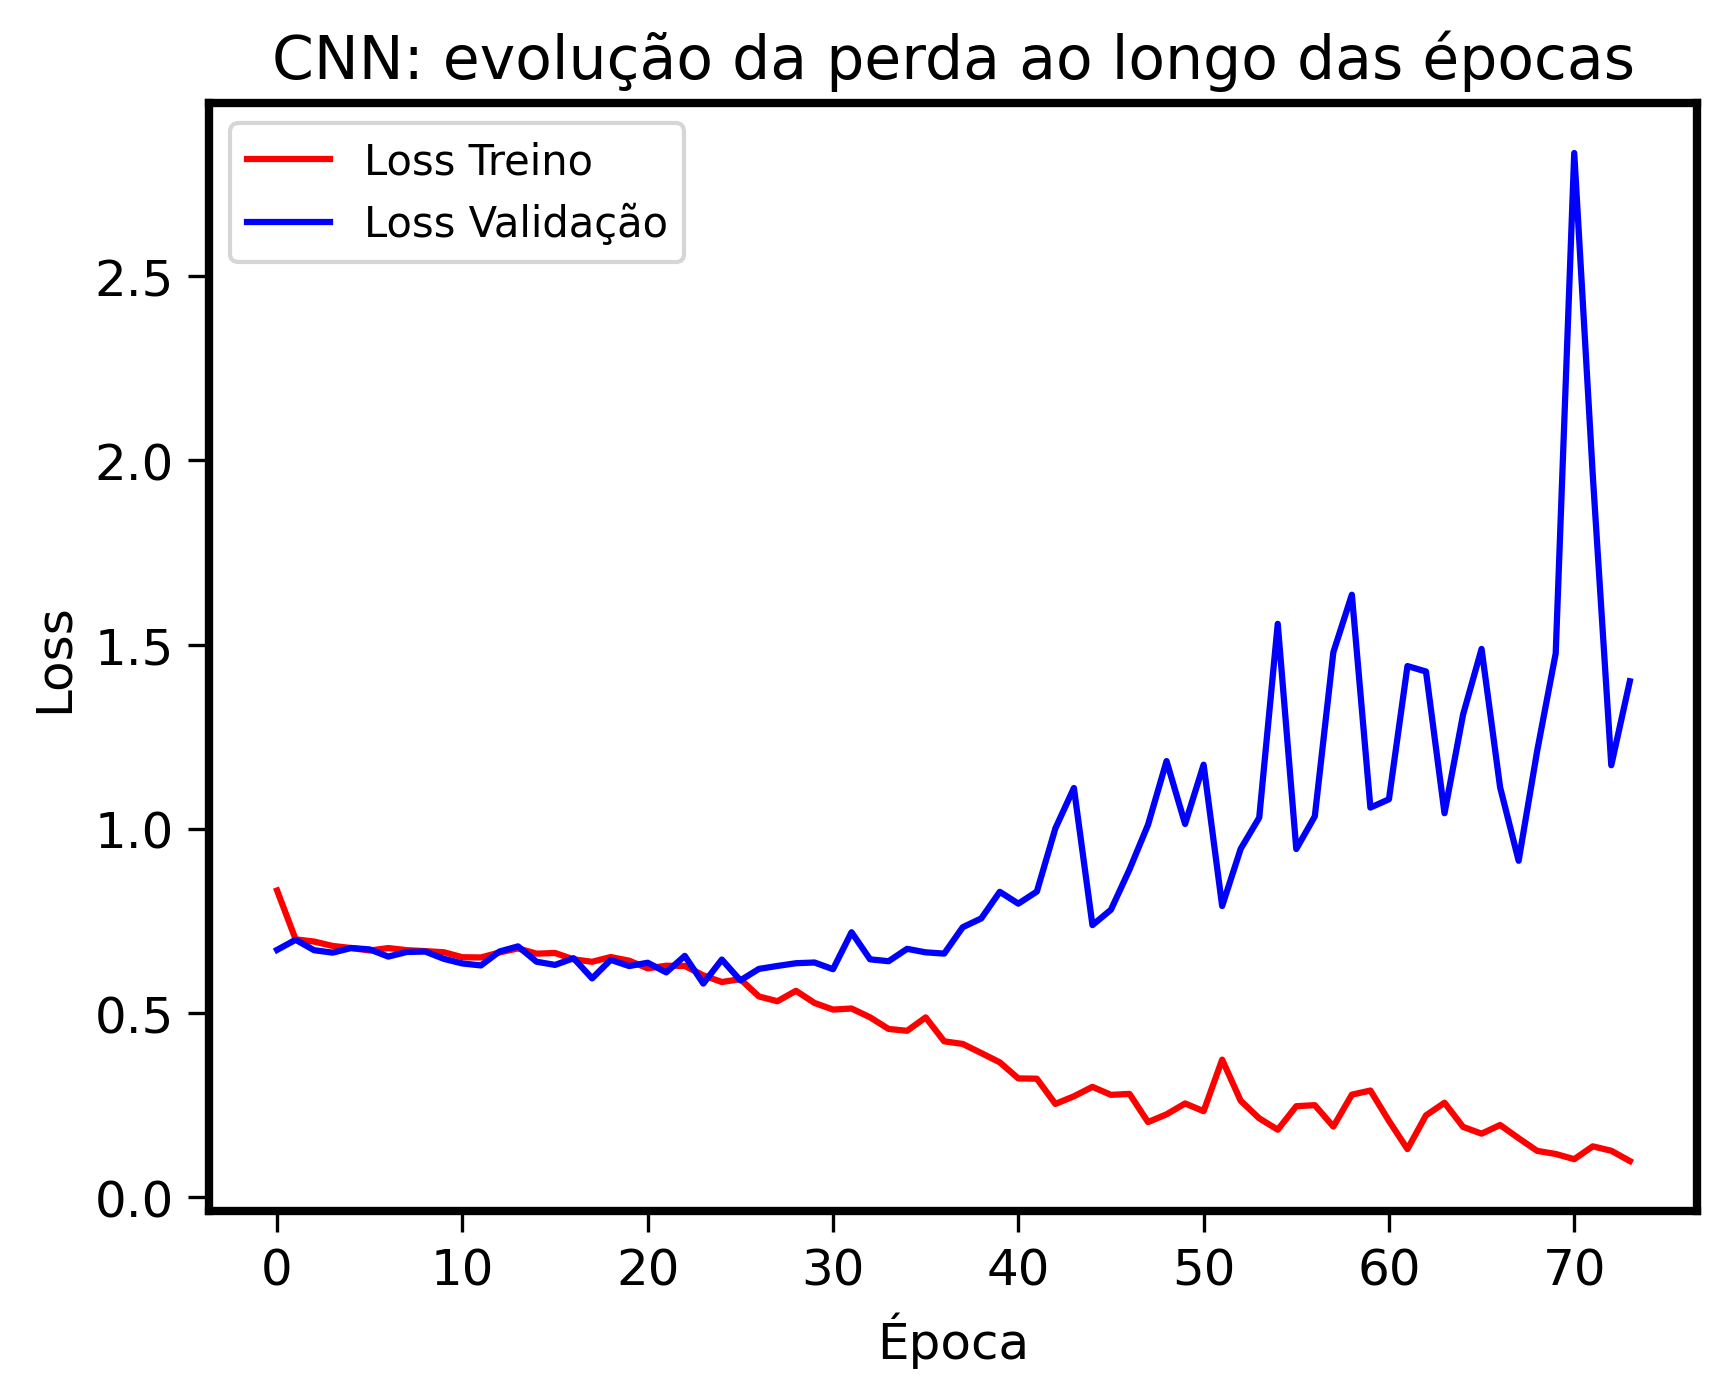

In [31]:
fig, ax = plt.subplots(dpi=300)
df_loss[["train_loss", "val_loss"]].rename(columns={"train_loss": "Loss Treino", "val_loss": "Loss Validação"}).plot(ax=ax, color=['red', 'blue'])
ax.legend()
plt.title("CNN: evolução da perda ao longo das épocas")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.savefig("../viz/loss_cnn.pdf")

---

# Resultados acurácia

In [32]:
resultados_df = pd.DataFrame({
    "Modelo": [
        "RegLog",
        "RegLog",
        "SVM",
        "SVM",
        "MLP",
        "MLP",
        "ConvNet",
    ],
    "Dataset": [
        "HOG",
        "LBP",
        "HOG",
        "LBP",
        "HOG",
        "LBP",
        "Apenas V&J",
    ],
    "Acurácia": [
        reglog_hog_acc,
        reglog_lbp_acc,
        svm_hog_acc,
        svm_lbp_acc,
        mlp_hog_acc,
        mlp_lbp_acc,
        cnet_acc,
    ]
})

In [33]:
resultados_df

,Modelo,Dataset,Acurácia
0,RegLog,HOG,0.499479
1,RegLog,LBP,0.525547
2,SVM,HOG,0.552659
3,SVM,LBP,0.614181
4,MLP,HOG,0.482795
5,MLP,LBP,0.617310
6,ConvNet,Apenas V&J,0.648958


In [34]:
colors = ["#98b35a", "#8dffff", "#ffa5f5"]
palette = sns.set_palette(sns.color_palette(colors))

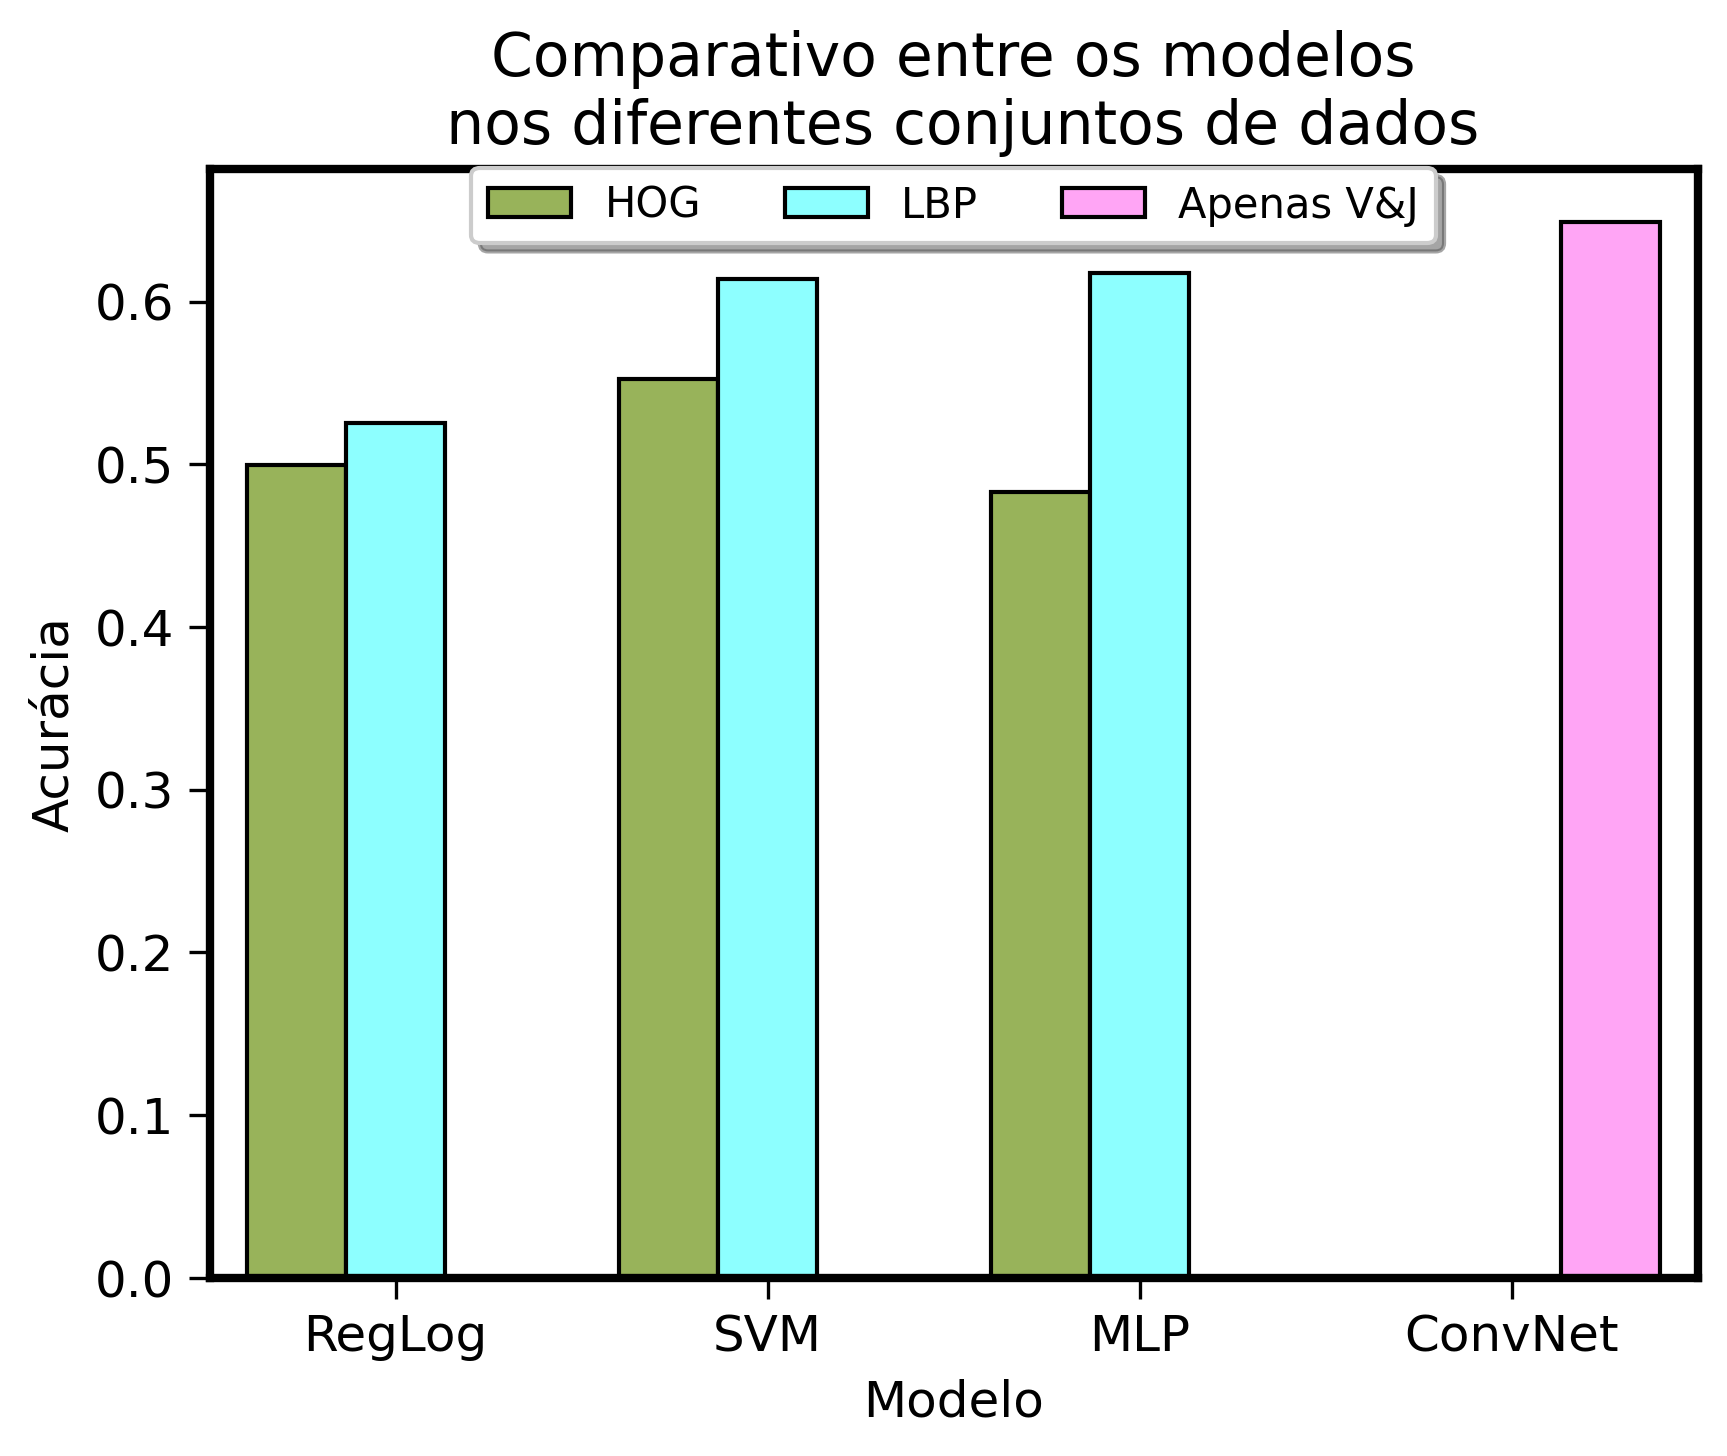

In [35]:
fig, ax = plt.subplots(dpi=300)

sns.barplot(data=resultados_df, x="Modelo", y="Acurácia", hue="Dataset", edgecolor='k', ax=ax, palette=palette, saturation=10)
ax.set_title("Comparativo entre os modelos\n nos diferentes conjuntos de dados")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3, fancybox=True, shadow=True)
plt.savefig("../viz/acuracia.pdf")

# Resultados matriz de confusão

In [36]:
print(svm_hog_report)

              precision    recall  f1-score   support

          -1       0.58      0.51      0.54       499
           1       0.53      0.60      0.56       460

    accuracy                           0.55       959
   macro avg       0.55      0.55      0.55       959
weighted avg       0.56      0.55      0.55       959



In [37]:
print(svm_lbp_report)

              precision    recall  f1-score   support

          -1       0.63      0.56      0.59       483
           1       0.60      0.67      0.63       476

    accuracy                           0.61       959
   macro avg       0.62      0.61      0.61       959
weighted avg       0.62      0.61      0.61       959



In [38]:
print(mlp_hog_report)

              precision    recall  f1-score   support

           0       0.48      1.00      0.65       463
           1       0.00      0.00      0.00       496

    accuracy                           0.48       959
   macro avg       0.24      0.50      0.33       959
weighted avg       0.23      0.48      0.31       959



In [39]:
print(mlp_lbp_report)

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       463
           1       0.63      0.62      0.63       496

    accuracy                           0.62       959
   macro avg       0.62      0.62      0.62       959
weighted avg       0.62      0.62      0.62       959



In [40]:
print(reglog_hog_report)

              precision    recall  f1-score   support

           0       0.48      0.54      0.51       463
           1       0.52      0.47      0.49       496

    accuracy                           0.50       959
   macro avg       0.50      0.50      0.50       959
weighted avg       0.50      0.50      0.50       959



In [41]:
print(reglog_lbp_report)

              precision    recall  f1-score   support

           0       0.51      0.60      0.55       463
           1       0.55      0.46      0.50       496

    accuracy                           0.53       959
   macro avg       0.53      0.53      0.52       959
weighted avg       0.53      0.53      0.52       959

